# Simulation of epidemic with two viruses

### The code
Here is the code for Simulation class and all its functionality.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import seaborn as sns

class Person:
    def __init__(self, location, alpha_V1, alpha_V2, alpha_recovered):
        self.location = location
        self.contacts = []
        self.state = [np.random.choice(["V1","V2","R","S"], p = [alpha_V1, alpha_V2, alpha_recovered,
                            1 - alpha_V1 - alpha_V2 - alpha_recovered])]

class Simulation:
    def __init__(self, m=20, n=30, p_occupied=.85, alpha_V1=.01, alpha_V2=.01,
                 alpha_recovered=0, beta_recovered=.01, beta_death=.0001, beta_sus=.01,
                 lambda_V1=.0125, lambda_V2=.0125, duration=500):
        self.params = {'m':m, 'n':n, 'p_occupied':p_occupied, 'alpha_V1':alpha_V1, 'alpha_V2':alpha_V2,
          'alpha_recovered':alpha_recovered, 'beta_recovered':beta_recovered, 'beta_death':beta_death,
          'beta_sus':beta_sus, 'lambda_V1':lambda_V1, 'lambda_V2':lambda_V2, 'N':duration}

        # Creating population
        self.population = []
        for x in range(m):
            for y in range(n):
                if np.random.random() < self.params['p_occupied']:
                    self.population.append(Person((x, y), alpha_V1, alpha_V2, alpha_recovered))

        # Finding all contacts within population
        for person1 in self.population:
            for person2 in self.population:
                if person1.location == person2.location: continue  # can't be contact of yourself
                if abs(person1.location[1] - person2.location[1]) <= 1 and \
                   abs(person1.location[0] - person2.location[0]) <= 1:
                    person1.contacts.append(person2)
        if 1 - (1 - max(lambda_V1, lambda_V2))**len(person1.contacts) + beta_recovered + beta_death > 1:
            raise Exception('With ' + str(len(person1.contacts)) + ' contacts, sum of probabilities of all '
                            'possible outcomes is greater, than 1!')

    def run(self):
        beta_recovered = self.params['beta_recovered']
        beta_death = self.params['beta_death']
        beta_sus = self.params['beta_sus']

        for t in range(self.params['N']):
            for person in self.population:
                person.state.append('?')

            for person in self.population:
                infestors_1 = 0 # This variable will show, how many people with V1 are in contacts
                infestors_2 = 0
                for contact in person.contacts: # counting infected contacts
                    if contact.state[t] == 'V1' or contact.state[t] == 'V1V2': infestors_1 += 1
                    if contact.state[t] == 'V2' or contact.state[t] == 'V1V2': infestors_2 += 1

                pV1 = 1-(1-self.params['lambda_V1'])**infestors_1    # prob to be infected with V1
                pV2 = 1-(1-self.params['lambda_V2'])**infestors_2
                pV1V2 = pV1 * pV2                                    # prob to be infected with both viruses at once

                if person.state[t] == 'S': person.state[t+1] = np.random.choice(['S', 'V1', 'V2', 'V1V2'],
                        p = [1 - pV1 - pV2 + pV1V2, pV1-pV1V2, pV2-pV1V2, pV1V2])
                if person.state[t] == 'V1': person.state[t+1] = np.random.choice(['R', 'V1V2', 'D', 'V1'],
                        p = [beta_recovered, pV2, beta_death, 1 - beta_recovered - pV2 - beta_death])
                if person.state[t] == 'V2': person.state[t+1] = np.random.choice(['R', 'V1V2', 'D', 'V2'],
                        p = [beta_recovered, pV1, beta_death, 1 - beta_recovered - pV1 - beta_death])
                if person.state[t] == 'V1V2': person.state[t+1] = np.random.choice(['R', 'D', 'V1V2'],
                        p = [beta_recovered/2, beta_death*2, 1 - beta_recovered/2 - beta_death*2])
                if person.state[t] == 'R': person.state[t+1] = np.random.choice(['R', 'S'],
                        p = [1-beta_sus, beta_sus])
                if person.state[t] == 'D': person.state[t+1] = 'D'  # No undead in this simulation

        count = pd.DataFrame()
        for t in range(self.params['N']+1):
            new_row = {'Time':t, 'S':0, 'V1':0, 'V2':0, 'V1V2':0, 'R':0, 'D':0}
            for person in self.population:
                new_row[person.state[t]] += 1
            count = pd.concat([count, pd.DataFrame(new_row, index = [t])], axis = 0)
            self.count = count

    def chart(self):
        count_long = pd.melt(self.count, id_vars = 'Time', value_vars = ['S', 'V1', 'V2', 'V1V2', 'R', 'D'],
                             value_name = 'Number', var_name = 'State').sort_values(['Time', 'Number'], ascending=[True, False])

        fig, ax = plt.subplots(figsize=(10, 7))
        sns.lineplot(data = count_long, x = 'Time', y = 'Number', hue = 'State',
                     palette={'S': 'green', 'V1': 'brown', 'V2': 'orange',
                              'V1V2': 'red', 'R': 'blue', 'D': 'grey'},
                     )
        plt.legend(title = 'State',
                   labels = ['Susceptible', 'Infected 1', 'Infected 2', 'Infected 1+2','Recovered', 'Dead'])
        plt.show()

    def plot_state(self, t):
        x = []
        y = []
        colors = []
        for person in self.population:
            x.append(person.location[0])
            y.append(person.location[1])
            state = person.state[t]
            if state == 'S': color = 'Susceptible'
            elif state == 'V1': color = 'Infected 1'
            elif state == 'V2': color = 'Infected 2'
            elif state == 'V1V2': color = 'Infected 1+2'
            elif state == 'R': color = 'Recovered'
            elif state == 'D': color = 'Dead'
            colors.append(color)

        fig, ax = plt.subplots(figsize=(12, 12))   # resolution of the plot will be 1200x1200

        ax = sns.scatterplot(x = x, y = y, hue = colors, s = 180,   # s = size of points
                        palette = {'Susceptible':'green', 'Infected 1':'brown', 'Infected 2':'orange',
                                   'Infected 1+2':'red', 'Recovered':'blue', 'Dead':'grey'},
                        hue_order = ['Susceptible', 'Infected 1', 'Infected 2', 'Infected 1+2',
                                     'Recovered', 'Dead'],
                        legend = 'full')
        plt.legend(title = 'State', loc='center left', bbox_to_anchor=(1, 0.5),
                   fontsize=16, title_fontsize=20, markerscale=2)
        plt.xticks([])  # no need numbers on axis
        plt.yticks([])
        plt.setp(ax.collections, zorder=100) # putting points above lines
        plt.title('State at Day ' + str(t), fontsize=24)
        plt.tight_layout() # currently, legend is outside of the plot, this line will correct plotted area

        segs = np.zeros((100000, 2, 2))
        segs_red = np.zeros((100000, 2, 2))
        i_green = 0
        i_red = 0
        for person in self.population:
            for contact in person.contacts:
                new_line = np.zeros((2, 2))
                new_line[0, 0] = person.location[0]
                new_line[0, 1] = person.location[1]
                new_line[1, 0] = contact.location[0]
                new_line[1, 1] = contact.location[1]

                states = [person.state[t], contact.state[t]]
                if not('D' in states):  # if person is dead, this contact doesn't exist anymore
                    if 'V1' in states or 'V2' in states or 'V1V2' in states:    # contacts with infected are red
                        segs_red[i_red, :, :] = new_line
                        i_red += 1
                    else:       # other contacts are green
                        segs[i_green, :, :] = new_line
                        i_green += 1

        ax.add_collection(LineCollection(segs, color = 'green'))
        ax.add_collection(LineCollection(segs_red, color = 'red'))
        plt.show()

    def max_infected(self):
        return (max(self.count.V1), max(self.count.V2))

    def peak_infected(self):
        peak_1 = np.where(self.count.V1 == max(self.count.V1))[0][0]
        peak_2 = np.where(self.count.V2 == max(self.count.V2))[0][0]
        return peak_1, peak_2

    def disease_start(self):
        dis_starts = pd.DataFrame()
        for i, person in enumerate(self.population):
            if 'V1' in person.state:
                V1_date = person.state.index('V1')
            else: V1_date = float('NaN')

            if 'V2' in person.state:
                V2_date = person.state.index('V2')
            else: V2_date = float('NaN')

            new_row = pd.DataFrame({'X':person.location[0], 'Y':person.location[1],
                                    'First V1 infection':V1_date, 'First V2 infection':V2_date}, index = [i])
            dis_starts = pd.concat([dis_starts, new_row], axis = 0)

        return dis_starts

    def ensemble_statistics(N, m=20, n=30, p_occupied=.85, alpha_V1=.01, alpha_V2=.01,
                 alpha_recovered=0, beta_recovered=.01, beta_death=.0001, beta_sus=.01,
                 lambda_V1=.0125, lambda_V2=.0125, duration=500):

        stat = pd.DataFrame(index = range(N))
        for i in range(N):
            sim = Simulation(m, n, p_occupied, alpha_V1, alpha_V2,
                             alpha_recovered, beta_recovered, beta_death,
                             beta_sus, lambda_V1, lambda_V2, duration)
            sim.run()
            stat.loc[i, '#Individ'] = len(sim.population)
            stat.loc[i, 'Max V1'], stat.loc[i, 'Max V2'] = sim.max_infected()
            stat.loc[i, 'Peak V1'], stat.loc[i, 'Peak V2'] = sim.peak_infected()
            stat.loc[i, '% V1'] = stat.loc[i, 'Max V1'] / len(sim.population)
            stat.loc[i, '% V2'] = stat.loc[i, 'Max V2'] / len(sim.population)

        sns.set_theme()
        sns.pairplot(stat)
        plt.show()

### Default parameters

Let's run the simulation with default parameters first.

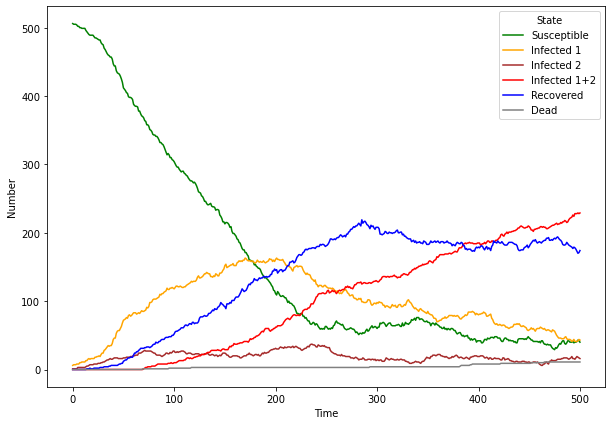

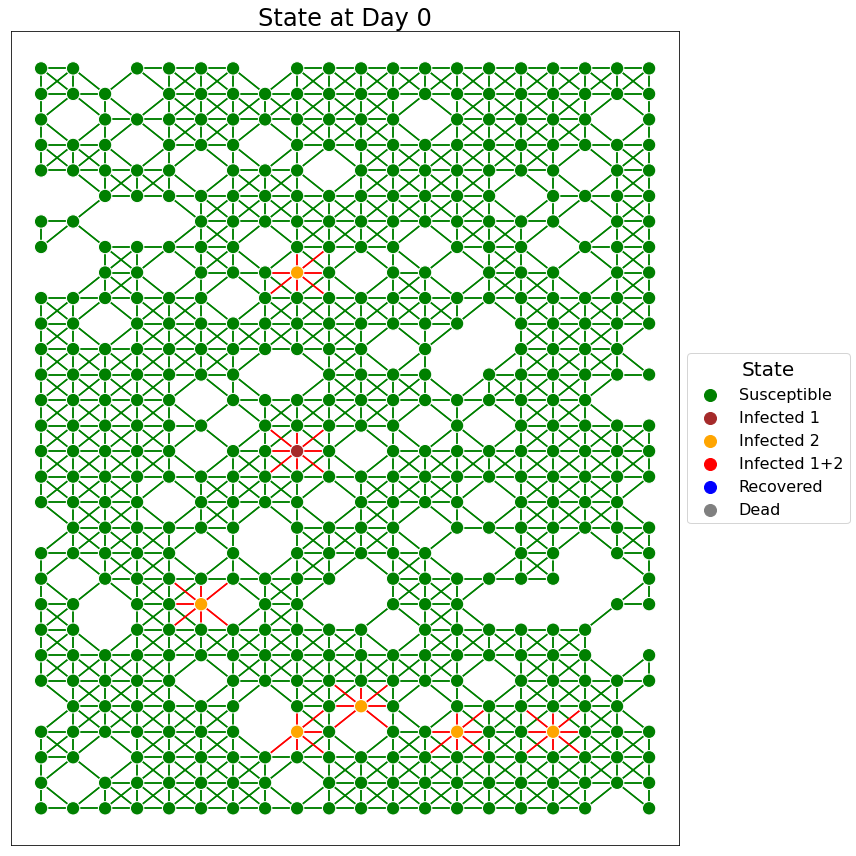

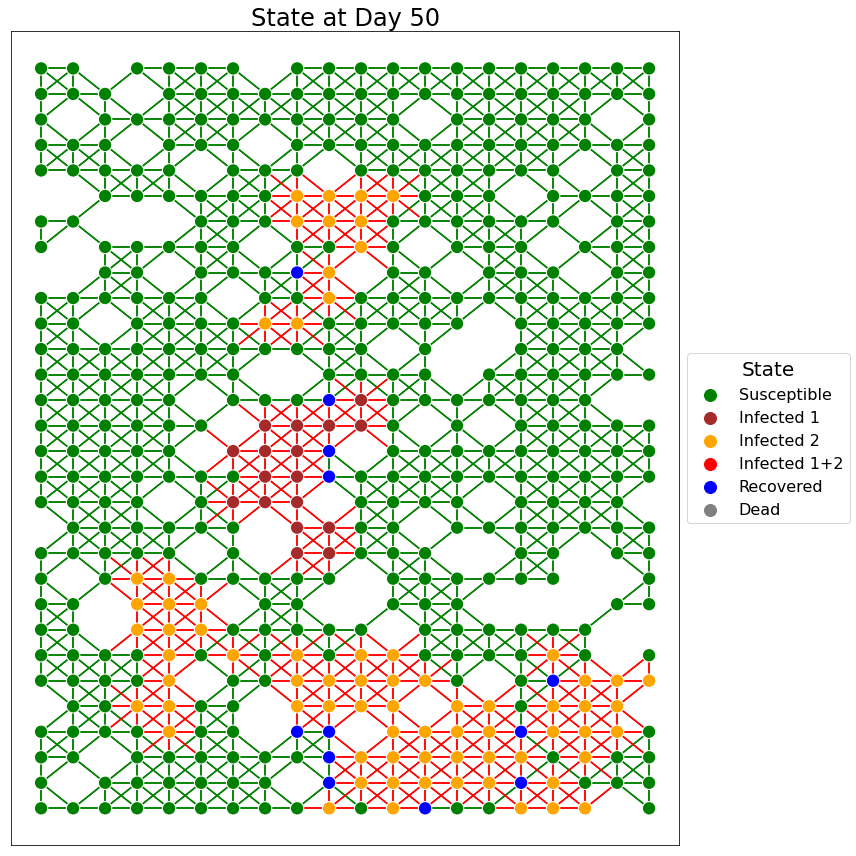

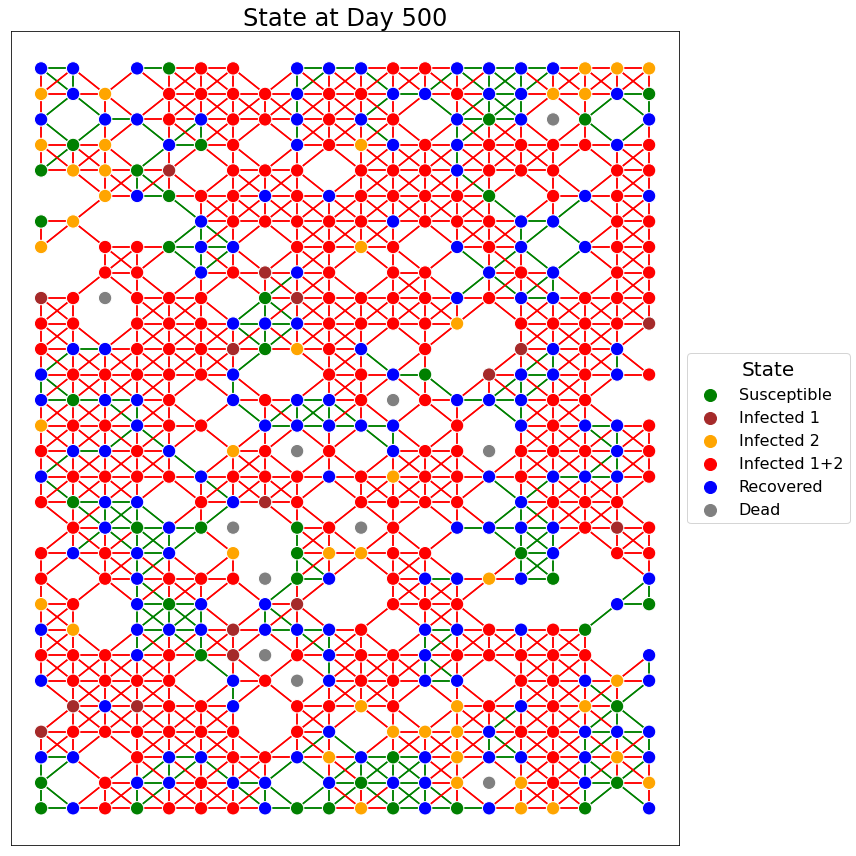

In [2]:
sim = Simulation()
sim.run()

sim.chart()
sim.plot_state(0)
sim.plot_state(50)
sim.plot_state(500)

### Bets sus = 0

Now we will change probability that an individual who has recovered
becomes susceptible again from 0.01 to 0 — now blue dots will always stay blue.

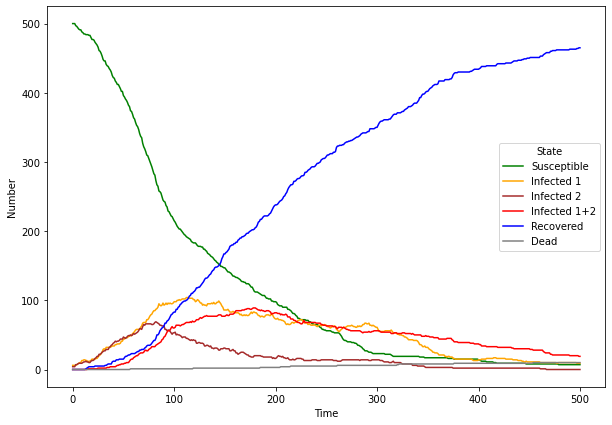

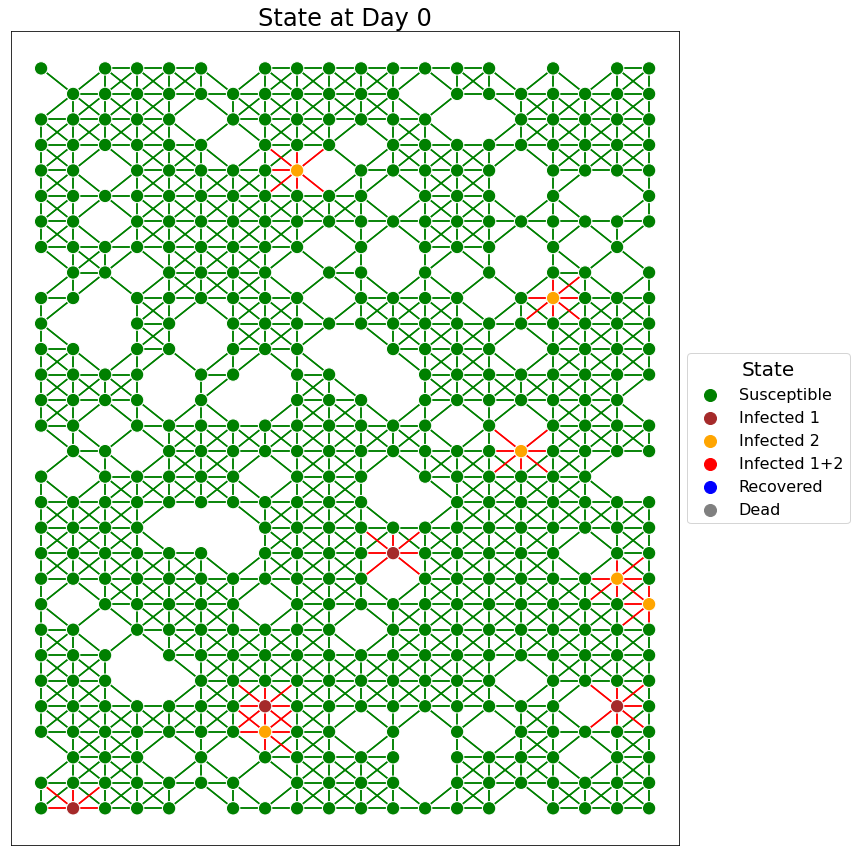

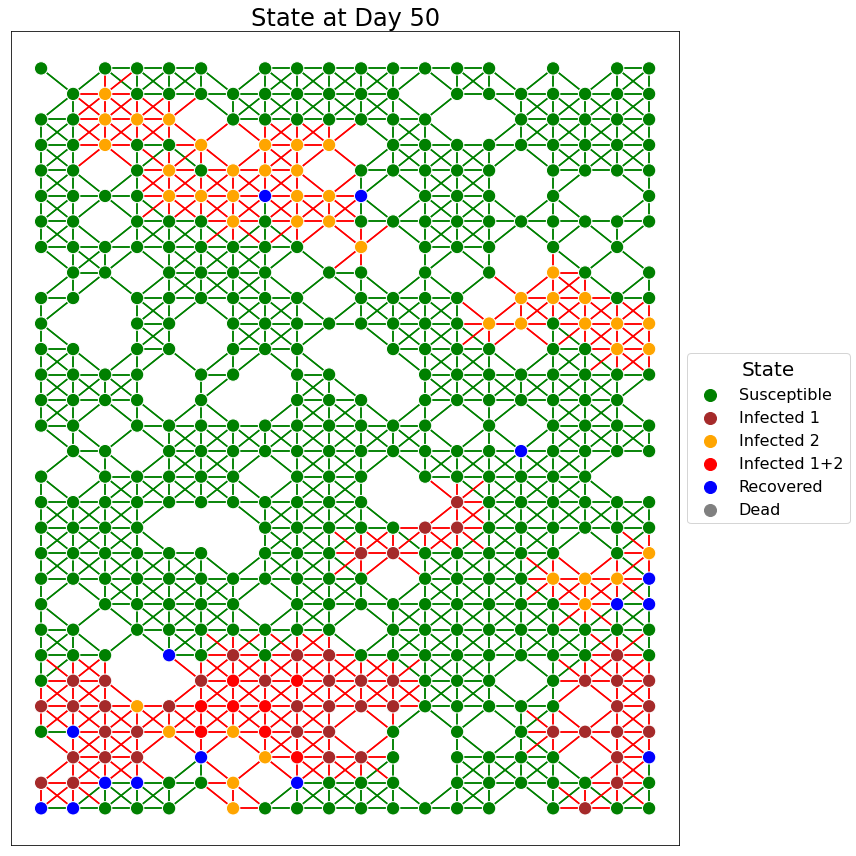

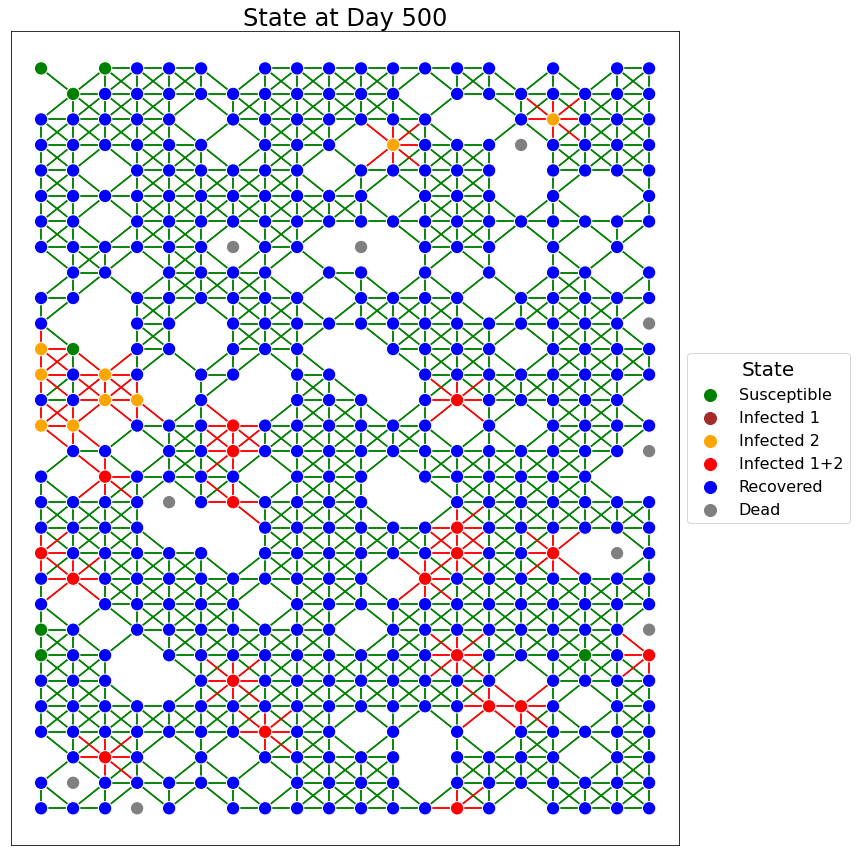

In [3]:
sim = Simulation(beta_sus=0)
sim.run()

sim.chart()
sim.plot_state(0)
sim.plot_state(50)
sim.plot_state(500)

There is no much difference at day 50 (and, of course, at day 0, since we didn't change parameters of initial state), but huge difference at day 500. Previously, by the end of simulation it was mostly a competition between number of recovered people and number of people who infected by both viruses. Almost all susceptible people were infected. But now almost all people are in recovered state by the end of simulation. Which means, that with default parameters people usually got infected more than once — after recovering they got infected again. As we can see, if they managed to avoid repeated infection, infection will be over much faster.

### Effect of P_occupied

Now we will iterate probability of cell being occupied from 0.1 to 1 and check, how it will affect initial state of population.

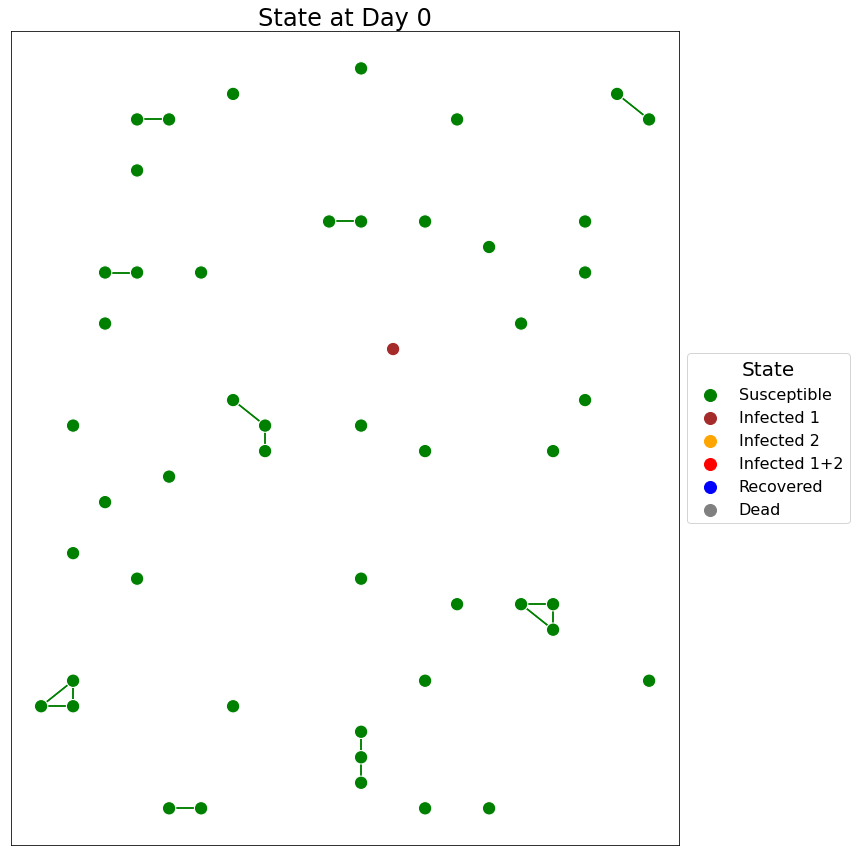

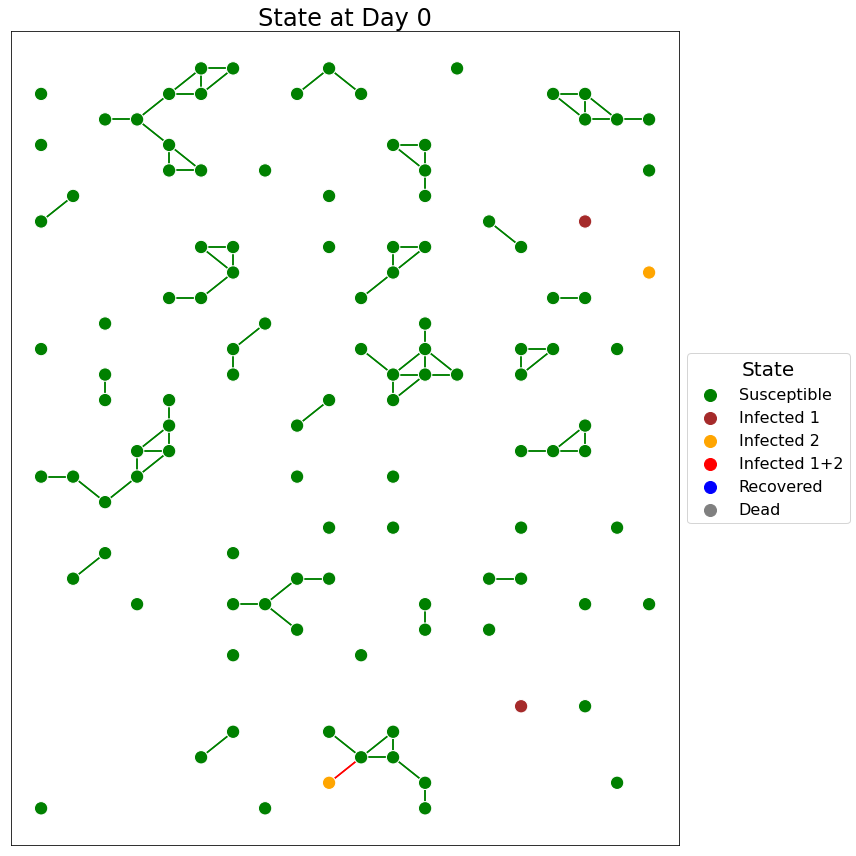

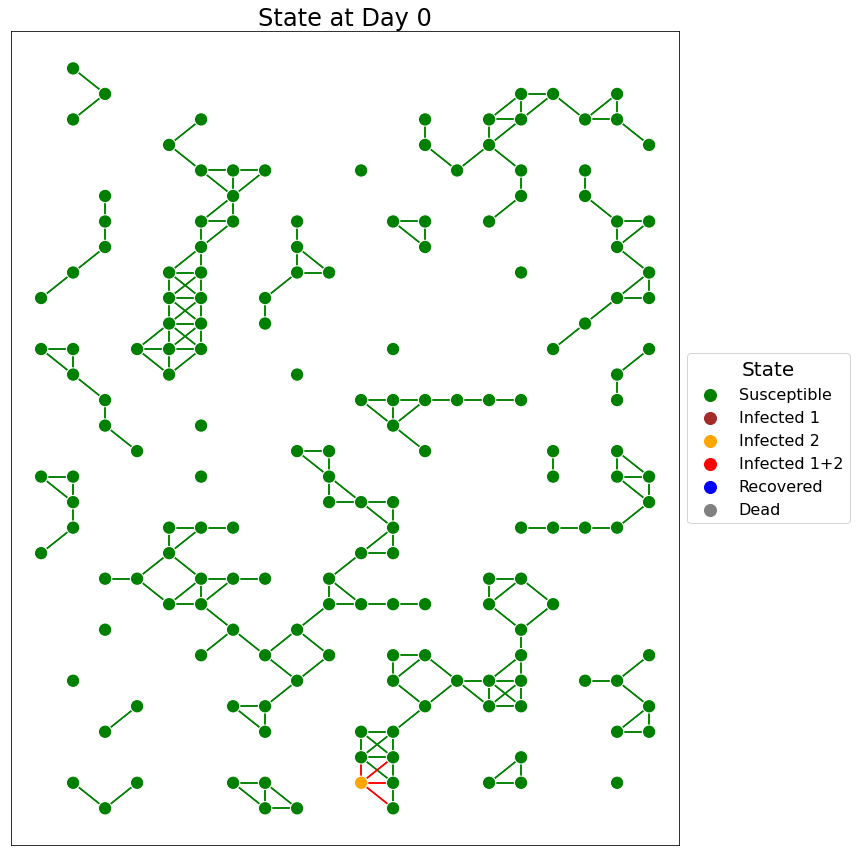

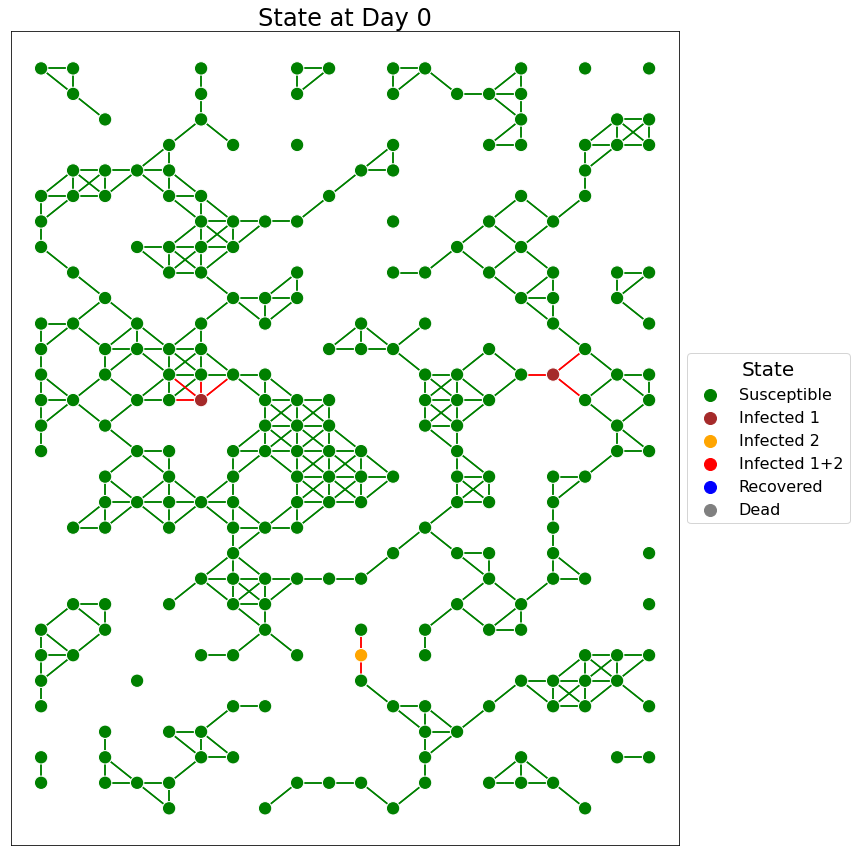

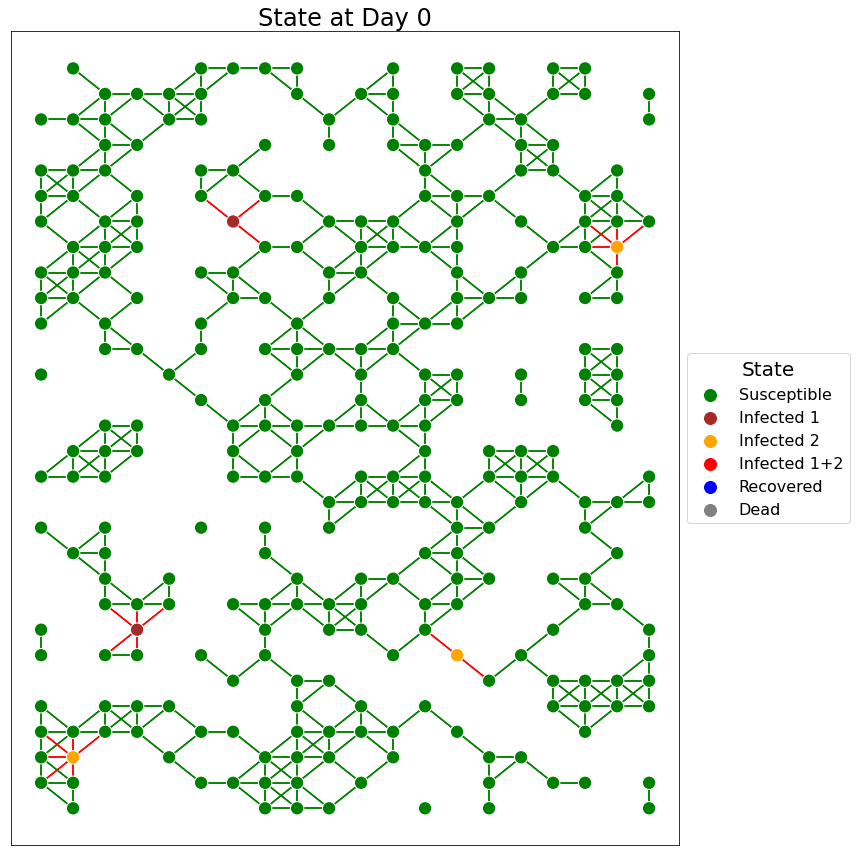

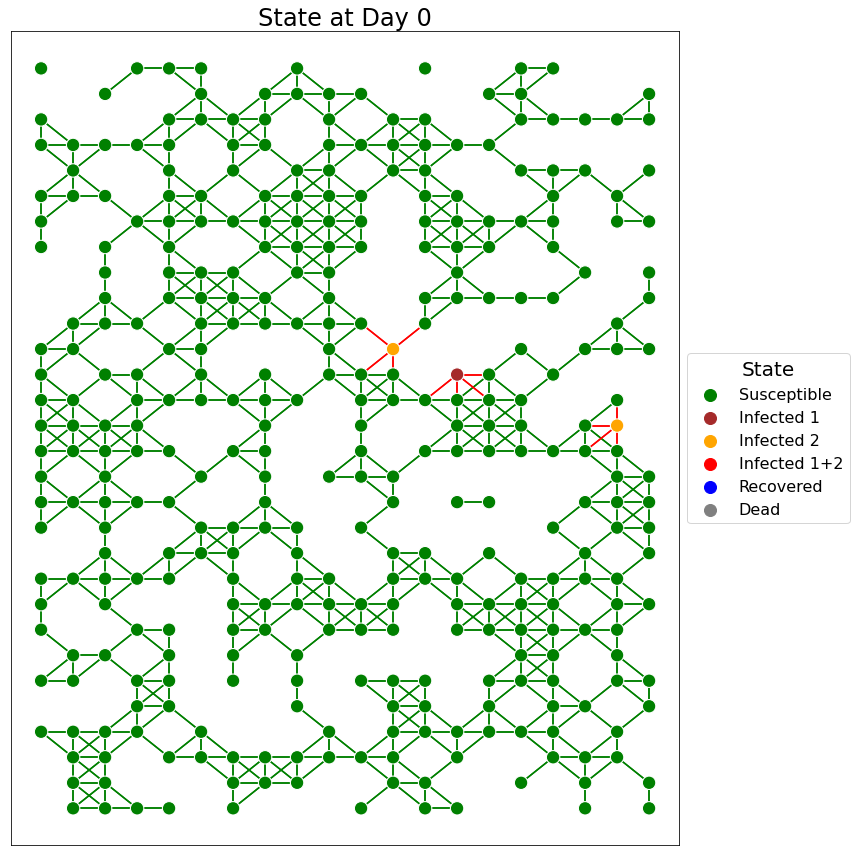

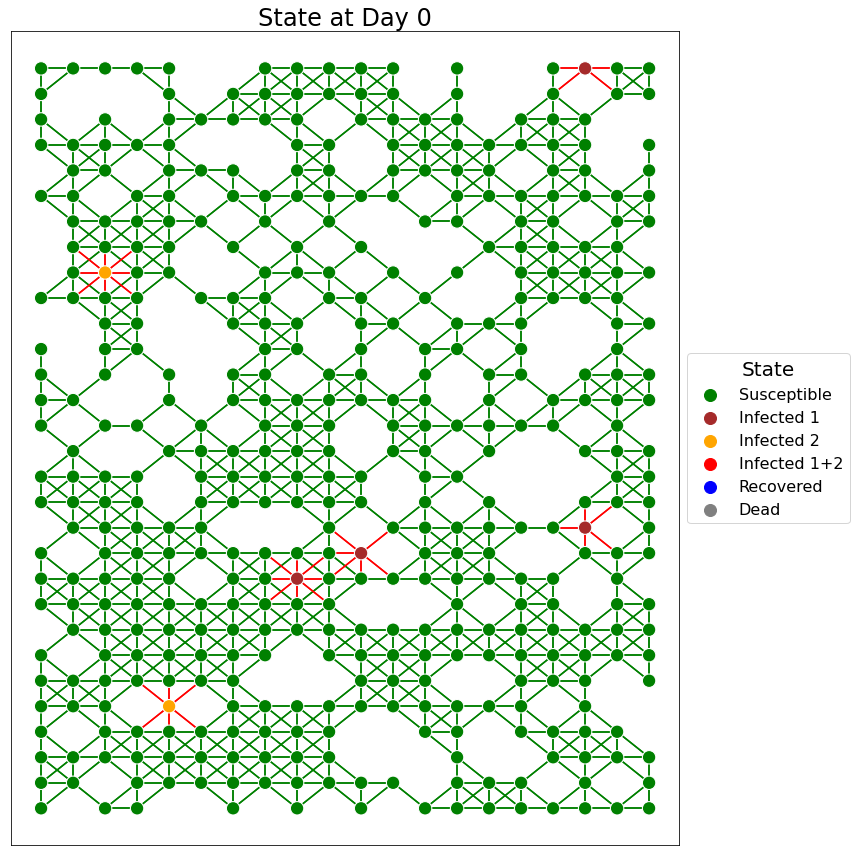

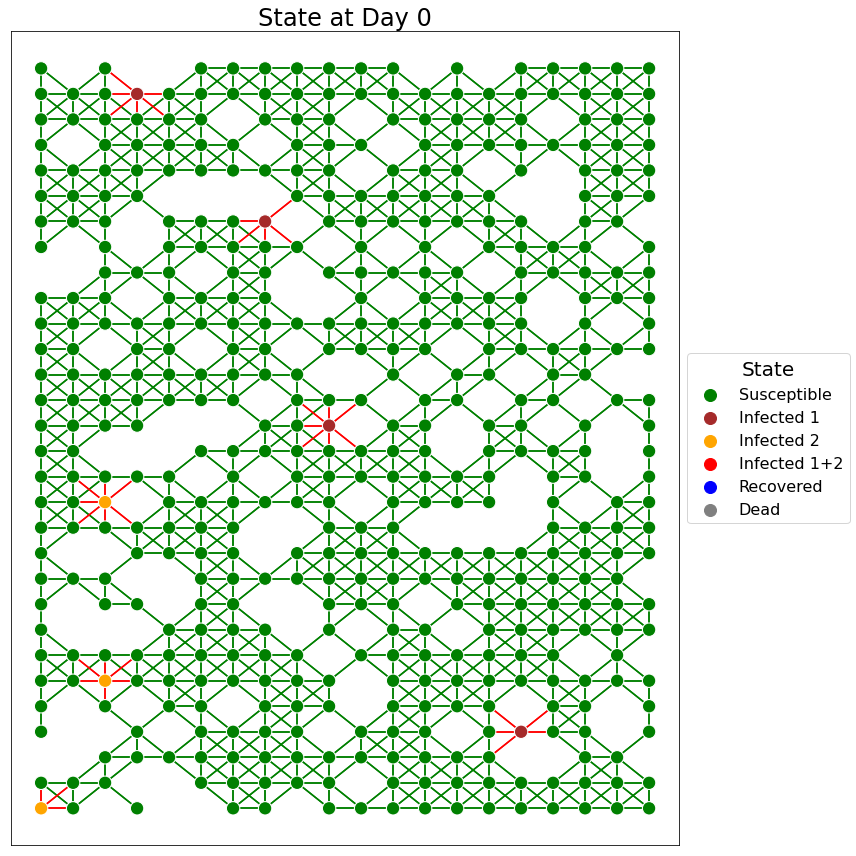

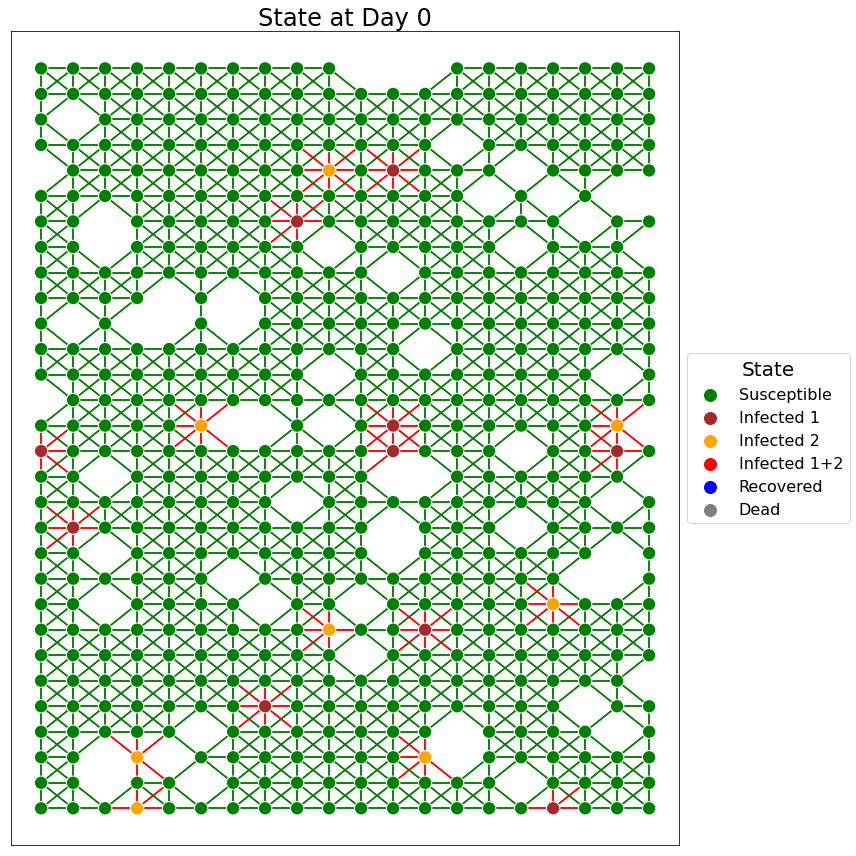

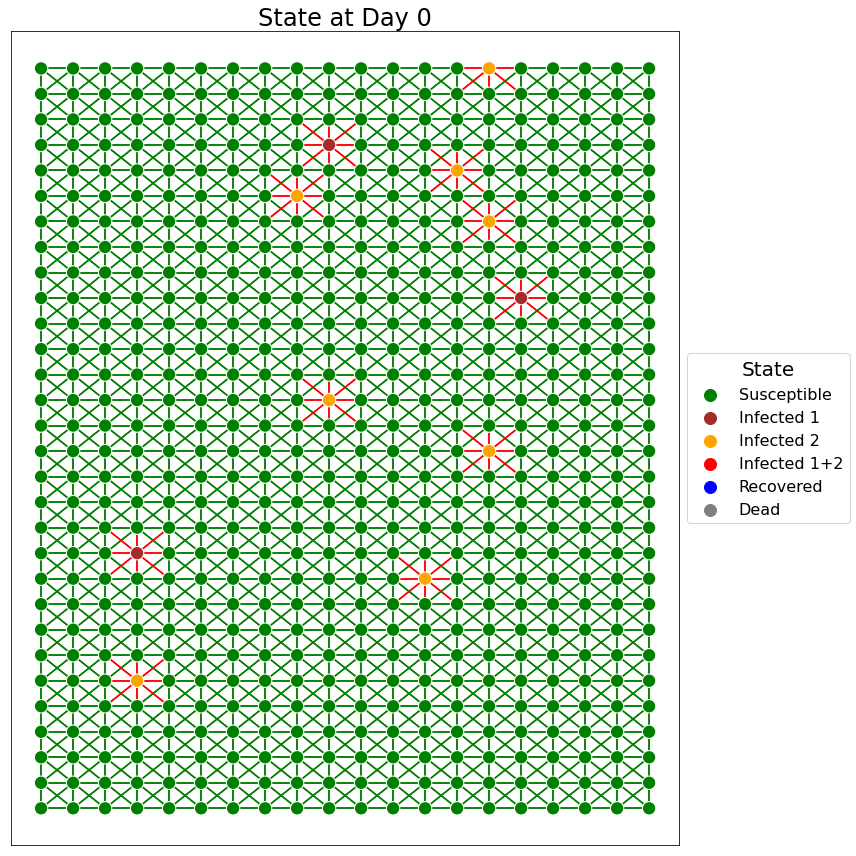

In [4]:
for p in np.arange(.1, 1.1, .1):
    sim = Simulation(p_occupied=p)
    sim.plot_state(0)

When probability for cell to be occupied is low, cells are splitted into groups which aren't connected with each other, and many groups don't have infected people within it. With P_occupied around 0.5 most cells are connected into one global group, though some sub-groups are connected with global group only by one person and it should slow spread of infection. As P-occupied increases further, number of semi-isolated subgroups goes down fast, and eventually all people have many connections, so infection suppose to spread faster.

### Ensemble statistics

Here we can check ensemble statistics functionality.

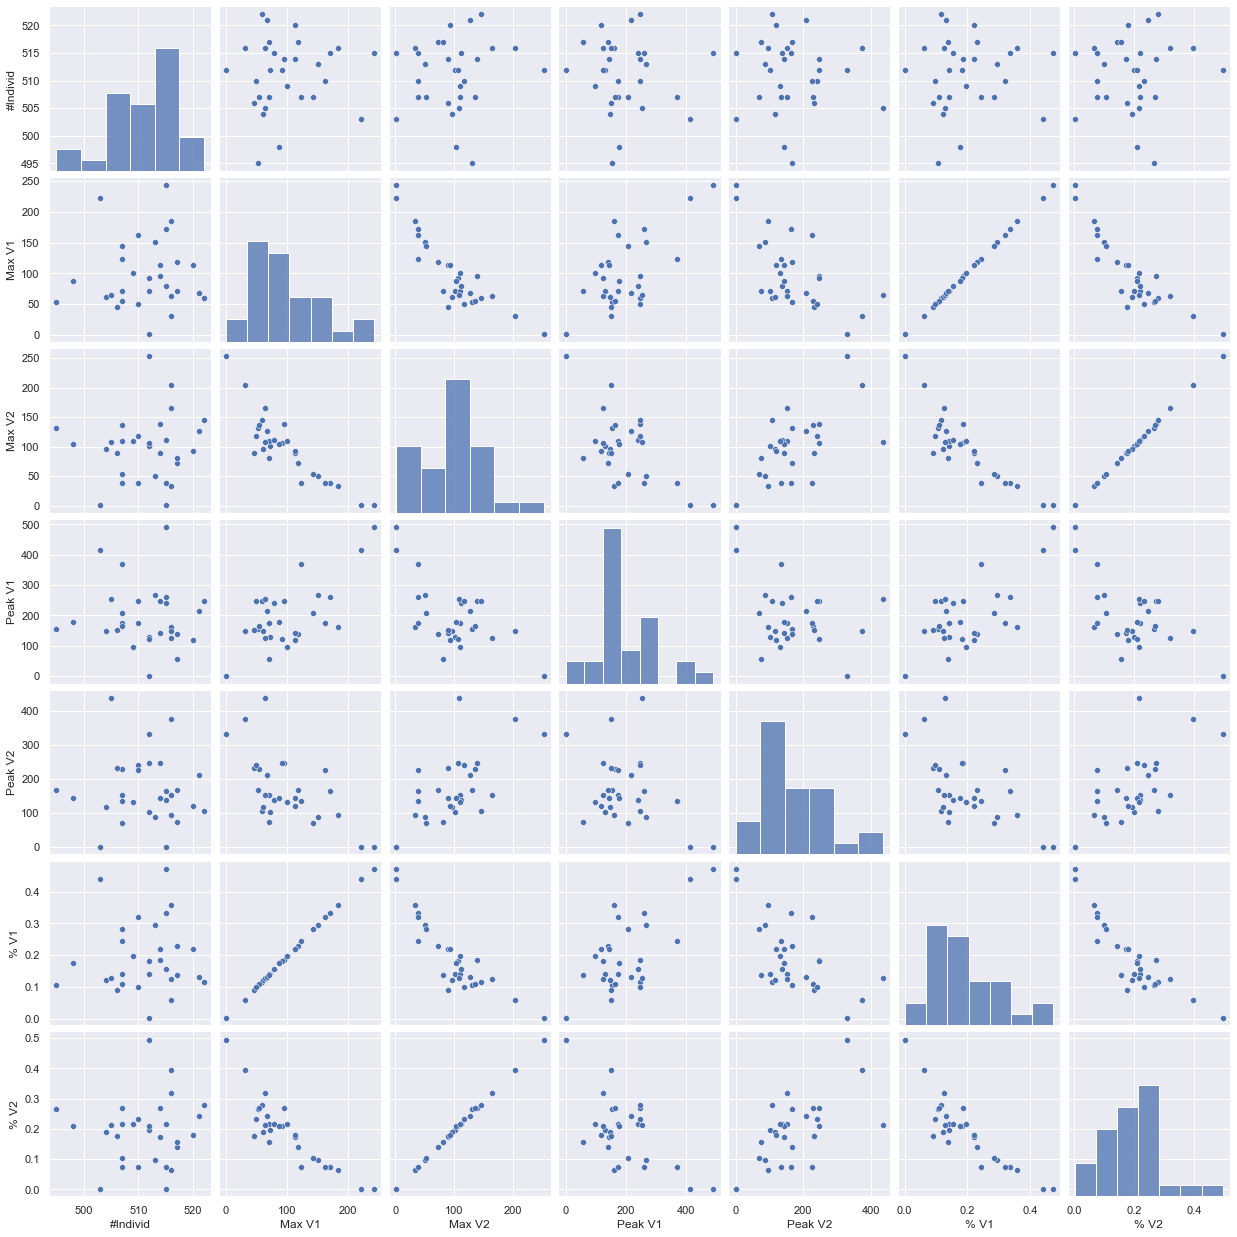

In [5]:
Simulation.ensemble_statistics(N = 30, duration = 500)